# Notebook 1: Preparación de Datos

**Proyecto:** Entrega Final - Optimización de Estrategias de Retención

**Autores:** Juan David Valencia, Juan Esteban Cuellar

**Fecha:** Noviembre 2025

---

## Objetivo

Este notebook implementa el **pipeline completo de preparación de datos** previo al entrenamiento de modelos de machine learning. Incluye:

1. **Feature Engineering:** Derivar variables de afinidades, crear interacciones, transformaciones
2. **Encoding:** One-hot encoding de variables categóricas
3. **Scaling:** Estandarización de variables numéricas
4. **Splitting:** División estratificada en train/validation/test (60/20/20)
5. **Validación:** Verificación de preservación de distribuciones

**Entrada:** `dataset_protegido (1).csv` (41,667 usuarios × 15 variables)

**Salida:** 
- `data/processed/train.csv` (25,000 usuarios)
- `data/processed/val.csv` (8,333 usuarios)
- `data/processed/test.csv` (8,333 usuarios)
- `models/feature_engineering_pipeline.pkl` (transformers guardados)

---

## 1. Setup y Carga de Datos

In [3]:
# Imports
import pandas as pd
import numpy as np
import ast
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Configuración
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
np.random.seed(42)  # Reproducibilidad

print("✅ Imports completados")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Imports completados
📅 Fecha de ejecución: 2025-11-26 23:29:27


In [4]:
# Cargar dataset
DATASET_PATH = '../dataset_protegido (1).csv'

print(f"📂 Cargando dataset desde: {DATASET_PATH}")
df = pd.read_csv(DATASET_PATH)

print(f"✅ Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"\n📊 Primeras 5 filas:")
df.head()

📂 Cargando dataset desde: ../dataset_protegido (1).csv
✅ Dataset cargado: 41,667 filas × 15 columnas

📊 Primeras 5 filas:


,country_code,uid,total_orders,total_orders_tmenos1,delta_orders,categoria_recencia,first_order_date,fourth_order_date,efo_to_four,main_category_counts,ka_type_counts,shop_name_counts,brand_name_counts,city_token,r_segment
0,CO,492892698476209,5,0,5,Frío (31–90d),2025-07-11,2025-07-19,8,"{'main_category007': 2, 'main_category021': 1,...","{'ka_type001': 2, 'ka_type003': 2, 'ka_type002...","{'shop_9847': 1, 'shop_7310': 1, 'shop_8864': ...","{'brand001': 3, 'brand641': 1, 'brand691': 1}",city002,r_segment001
1,CO,492892701117693,9,0,9,Tibio (15–30d),2025-08-18,2025-08-22,4,"{'main_category023': 1, 'main_category021': 5,...","{'ka_type001': 3, 'ka_type002': 6}","{'shop_334': 1, 'shop_10579': 1, 'shop_6584': ...","{'brand352': 1, 'brand458': 1, 'brand580': 1, ...",city001,r_segment002
2,CO,492892701156786,9,0,9,Frío (31–90d),2025-07-14,2025-07-16,2,"{'main_category007': 1, 'main_category021': 1,...","{'ka_type001': 4, 'ka_type003': 1, 'ka_type002...","{'shop_7148': 1, 'shop_5045': 2, 'shop_2485': ...","{'brand001': 1, 'brand352': 3, 'brand502': 1, ...",city001,r_segment001
3,CO,492892701766066,4,0,4,Frío (31–90d),2025-08-08,2025-08-17,9,"{'main_category021': 1, 'main_category007': 1,...",{'ka_type002': 4},"{'shop_5319': 1, 'shop_5147': 1, 'shop_5018': ...","{'brand352': 1, 'brand354': 1, 'brand580': 1, ...",city006,r_segment002
4,CO,492892702909369,28,0,28,Tibio (15–30d),2025-07-04,2025-07-10,6,"{'main_category021': 3, 'main_category018': 1,...","{'ka_type001': 14, 'ka_type003': 10, 'ka_type0...","{'shop_5050': 2, 'shop_9287': 1, 'shop_8208': ...","{'brand001': 10, 'brand664': 1, 'brand195': 1,...",city006,r_segment001


In [5]:
# Información básica del dataset
print("📋 Información del Dataset:\n")
df.info()

print(f"\n📊 Estadísticas Descriptivas (Numéricas):\n")
df.describe()

📋 Información del Dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41667 entries, 0 to 41666
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   country_code          41667 non-null  object
 1   uid                   41667 non-null  int64 
 2   total_orders          41667 non-null  int64 
 3   total_orders_tmenos1  41667 non-null  int64 
 4   delta_orders          41667 non-null  int64 
 5   categoria_recencia    41667 non-null  object
 6   first_order_date      41667 non-null  object
 7   fourth_order_date     41667 non-null  object
 8   efo_to_four           41667 non-null  int64 
 9   main_category_counts  41667 non-null  object
 10  ka_type_counts        41667 non-null  object
 11  shop_name_counts      41667 non-null  object
 12  brand_name_counts     41667 non-null  object
 13  city_token            41667 non-null  object
 14  r_segment             41667 non-null  object
dtypes: int64

,uid,total_orders,total_orders_tmenos1,delta_orders,efo_to_four
count,4.166700e+04,41667.000000,41667.000000,41667.000000,41667.000000
mean,4.928934e+14,7.199198,0.345693,6.853505,14.941200
std,2.734000e+08,4.942332,0.828306,4.957327,8.139177
min,4.928927e+14,4.000000,0.000000,1.000000,0.000000
25%,4.928932e+14,4.000000,0.000000,4.000000,8.000000
50%,4.928934e+14,6.000000,0.000000,5.000000,14.000000
75%,4.928936e+14,8.000000,0.000000,8.000000,21.000000
max,4.928937e+14,108.000000,3.000000,108.000000,30.000000


## 2. Feature Engineering

### 2.1 Parsing de Columnas Diccionario

Las columnas `main_category_counts`, `ka_type_counts`, `shop_name_counts`, `brand_name_counts` están almacenadas como strings de diccionarios. Necesitamos parsearlas.

In [6]:
# Parsear columnas diccionario
dict_columns = ['main_category_counts', 'ka_type_counts', 'shop_name_counts', 'brand_name_counts']

print("🔧 Parseando columnas de diccionarios...\n")
for col in dict_columns:
    if col in df.columns:
        try:
            df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
            print(f"  ✓ {col} parseado correctamente")
        except Exception as e:
            print(f"  ✗ Error parseando {col}: {str(e)}")

print("\n✅ Parseo completado")

# Verificar ejemplo de diccionario parseado
print(f"\n📄 Ejemplo de main_category_counts parseado (usuario 0):")
print(df['main_category_counts'].iloc[0])

🔧 Parseando columnas de diccionarios...

  ✓ main_category_counts parseado correctamente
  ✓ ka_type_counts parseado correctamente
  ✓ shop_name_counts parseado correctamente
  ✓ brand_name_counts parseado correctamente

✅ Parseo completado

📄 Ejemplo de main_category_counts parseado (usuario 0):
{'main_category007': 2, 'main_category021': 1, 'main_category027': 1, 'main_category010': 1}


### 2.2 Derivar Features de Afinidades

De las columnas diccionario, vamos a derivar features agregados:
- **Categoría dominante:** La categoría con más órdenes
- **Diversidad de categorías:** Índice de Shannon
- **Número de categorías/tiendas/marcas:** Conteos únicos
- **Ratio de brand001:** Proporción de órdenes de la marca dominante

In [7]:
# Función para calcular índice de Shannon (diversidad)
def shannon_entropy(counts_dict):
    """
    Calcula el índice de Shannon (entropía) de un diccionario de conteos.
    Mayor entropía = mayor diversidad.
    """
    if not isinstance(counts_dict, dict) or len(counts_dict) == 0:
        return 0.0
    
    total = sum(counts_dict.values())
    if total == 0:
        return 0.0
    
    entropy = 0
    for count in counts_dict.values():
        if count > 0:
            p = count / total
            entropy -= p * np.log(p)
    
    return entropy

# Función para obtener categoría dominante
def get_dominant_category(counts_dict):
    """
    Retorna la categoría con mayor número de órdenes.
    """
    if not isinstance(counts_dict, dict) or len(counts_dict) == 0:
        return 'unknown'
    
    return max(counts_dict, key=counts_dict.get)

print("🔧 Derivando features de afinidades...\n")

# 1. Categoría dominante
df['dominant_category'] = df['main_category_counts'].apply(get_dominant_category)
print("  ✓ dominant_category creado")

# 2. Diversidad de categorías (Shannon)
df['category_diversity'] = df['main_category_counts'].apply(shannon_entropy)
print("  ✓ category_diversity creado")

# 3. Número de categorías únicas
df['num_categories'] = df['main_category_counts'].apply(lambda x: len(x) if isinstance(x, dict) else 0)
print("  ✓ num_categories creado")

# 4. Número de tiendas únicas
df['num_shops'] = df['shop_name_counts'].apply(lambda x: len(x) if isinstance(x, dict) else 0)
print("  ✓ num_shops creado")

# 5. Número de marcas únicas
df['num_brands'] = df['brand_name_counts'].apply(lambda x: len(x) if isinstance(x, dict) else 0)
print("  ✓ num_brands creado")

# 6. Ratio de brand001 (marca dominante)
def get_brand001_ratio(brand_dict, total_orders):
    if not isinstance(brand_dict, dict) or total_orders == 0:
        return 0.0
    return brand_dict.get('brand001', 0) / total_orders

df['brand001_ratio'] = df.apply(lambda row: get_brand001_ratio(row['brand_name_counts'], row['total_orders']), axis=1)
print("  ✓ brand001_ratio creado")

print("\n✅ Features de afinidades creados")

# Verificar nuevas features
print("\n📊 Estadísticas de nuevas features:")
df[['dominant_category', 'category_diversity', 'num_categories', 'num_shops', 'num_brands', 'brand001_ratio']].describe()

🔧 Derivando features de afinidades...

  ✓ dominant_category creado
  ✓ category_diversity creado
  ✓ num_categories creado
  ✓ num_shops creado
  ✓ num_brands creado
  ✓ brand001_ratio creado

✅ Features de afinidades creados

📊 Estadísticas de nuevas features:


,category_diversity,num_categories,num_shops,num_brands,brand001_ratio
count,41667.000000,41667.000000,41667.000000,41667.000000,41667.000000
mean,1.063845,3.672787,5.355701,3.678019,0.435936
std,0.473800,1.751992,3.338799,2.211994,0.352244
min,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.693147,2.000000,3.000000,2.000000,0.166667
50%,1.054920,3.000000,5.000000,3.000000,0.400000
75%,1.386294,5.000000,6.000000,5.000000,0.714286
max,2.640947,17.000000,57.000000,32.000000,4.000000


### 2.3 Features Temporales

Derivar features de las fechas.

In [8]:
print("🔧 Derivando features temporales...\n")

# Convertir columnas de fecha a datetime
df['first_order_date'] = pd.to_datetime(df['first_order_date'])
df['fourth_order_date'] = pd.to_datetime(df['fourth_order_date'])

# 1. Es fin de semana la primera orden?
df['is_weekend_first_order'] = df['first_order_date'].dt.dayofweek.isin([5, 6]).astype(int)
print("  ✓ is_weekend_first_order creado")

# 2. Mes de la primera orden (para capturar estacionalidad)
df['first_order_month'] = df['first_order_date'].dt.month
print("  ✓ first_order_month creado")

# 3. Días desde la primera orden (para feature de "antigüedad")
reference_date = df['first_order_date'].max()  # Usar la fecha más reciente como referencia
df['days_since_first_order'] = (reference_date - df['first_order_date']).dt.days
print("  ✓ days_since_first_order creado")

print("\n✅ Features temporales creados")

# Verificar distribución de fin de semana
print(f"\n📊 Distribución is_weekend_first_order:")
print(df['is_weekend_first_order'].value_counts(normalize=True) * 100)

🔧 Derivando features temporales...

  ✓ is_weekend_first_order creado
  ✓ first_order_month creado
  ✓ days_since_first_order creado

✅ Features temporales creados

📊 Distribución is_weekend_first_order:
is_weekend_first_order
0    64.194686
1    35.805314
Name: proportion, dtype: float64


### 2.4 Features de Transformación Numérica

Algunas variables numéricas tienen distribuciones asimétricas (skewness > 3). Vamos a aplicar transformación logarítmica.

🔧 Aplicando transformaciones numéricas...

  ✓ log_total_orders creado
  ✓ log_efo_to_four creado
  ✓ orders_per_day creado

✅ Transformaciones numéricas aplicadas


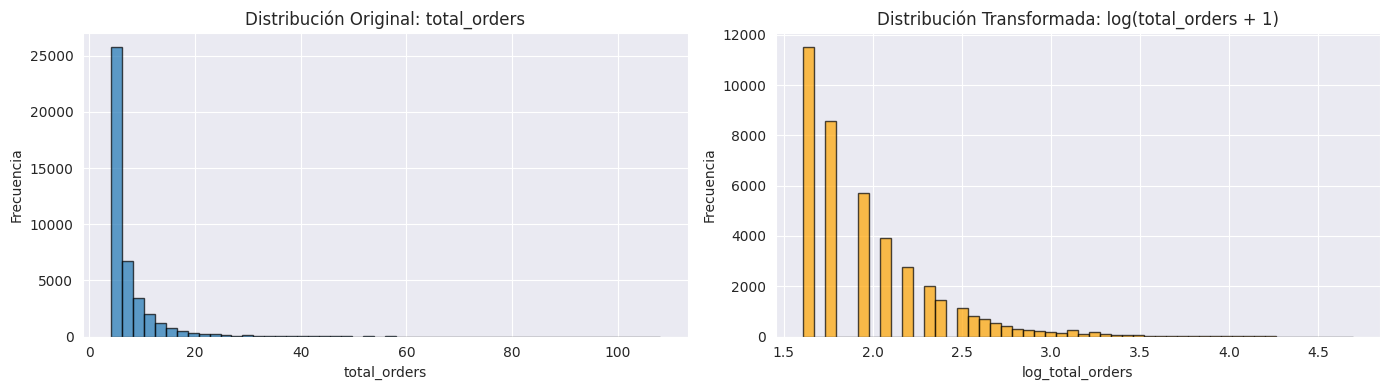


📊 Asimetría total_orders: 4.44
📊 Asimetría log_total_orders: 1.42
👉 Transformación logarítmica reduce la asimetría


In [9]:
print("🔧 Aplicando transformaciones numéricas...\n")

# Log-transform de variables con alta asimetría
# Usar log1p para evitar log(0)
df['log_total_orders'] = np.log1p(df['total_orders'])
print("  ✓ log_total_orders creado")

df['log_efo_to_four'] = np.log1p(df['efo_to_four'])
print("  ✓ log_efo_to_four creado")

# Órdenes por día (velocidad promedio de órdenes)
# Evitar división por cero
df['orders_per_day'] = df['total_orders'] / (df['days_since_first_order'] + 1)
print("  ✓ orders_per_day creado")

print("\n✅ Transformaciones numéricas aplicadas")

# Comparar distribuciones antes y después de log-transform
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Antes
axes[0].hist(df['total_orders'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución Original: total_orders', fontsize=12)
axes[0].set_xlabel('total_orders')
axes[0].set_ylabel('Frecuencia')

# Después
axes[1].hist(df['log_total_orders'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Distribución Transformada: log(total_orders + 1)', fontsize=12)
axes[1].set_xlabel('log_total_orders')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

print(f"\n📊 Asimetría total_orders: {df['total_orders'].skew():.2f}")
print(f"📊 Asimetría log_total_orders: {df['log_total_orders'].skew():.2f}")
print("👉 Transformación logarítmica reduce la asimetría")

### 2.5 Crear Variable Objetivo (Target)

Necesitamos crear dos targets:
- **`high_growth`:** Clasificación binaria (1 si delta_orders > 8, 0 si no)
- **`delta_orders`:** Ya existe, es nuestra variable de regresión

🎯 Creando variable objetivo para clasificación...

  ✓ high_growth creado (threshold: 8 órdenes)

📊 Distribución de high_growth:
high_growth
0    79.640963
1    20.359037
Name: proportion, dtype: float64

📊 Estadísticas de delta_orders por clase:
               count       mean       std  min   25%   50%   75%    max
high_growth                                                            
0            33184.0   5.057287  1.511432  1.0   4.0   5.0   6.0    8.0
1             8483.0  13.879995  7.055694  9.0  10.0  12.0  15.0  108.0


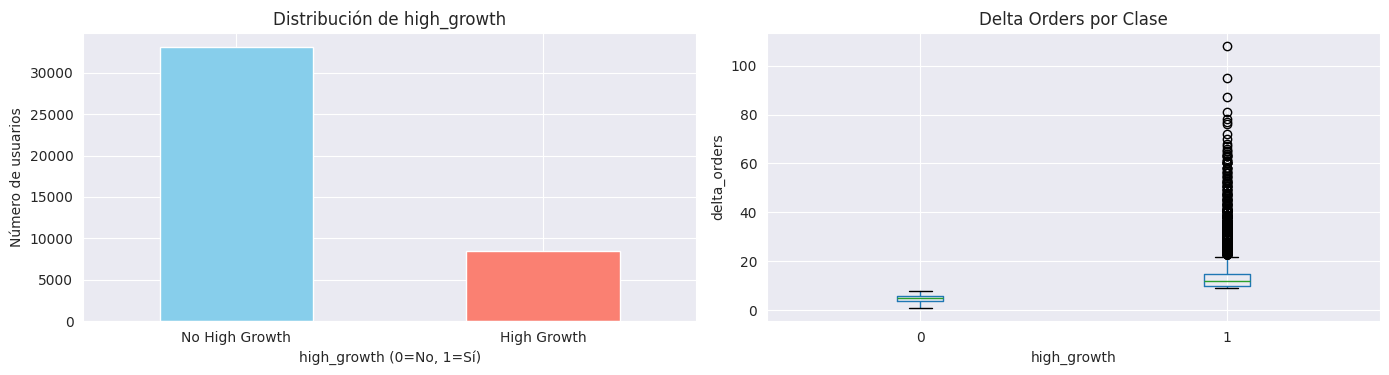


✅ Variables objetivo listas:
   - high_growth (clasificación): 8,483 usuarios high-growth (20.4%)
   - delta_orders (regresión): promedio 6.85 órdenes


In [10]:
print("🎯 Creando variable objetivo para clasificación...\n")

# Threshold de 8 órdenes define usuarios de alto crecimiento (top ~20%)
THRESHOLD_HIGH_GROWTH = 8

df['high_growth'] = (df['delta_orders'] > THRESHOLD_HIGH_GROWTH).astype(int)

print(f"  ✓ high_growth creado (threshold: {THRESHOLD_HIGH_GROWTH} órdenes)")

# Distribución de la variable objetivo
print(f"\n📊 Distribución de high_growth:")
print(df['high_growth'].value_counts(normalize=True) * 100)

print(f"\n📊 Estadísticas de delta_orders por clase:")
print(df.groupby('high_growth')['delta_orders'].describe())

# Visualizar distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Conteo
df['high_growth'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Distribución de high_growth', fontsize=12)
axes[0].set_xlabel('high_growth (0=No, 1=Sí)')
axes[0].set_ylabel('Número de usuarios')
axes[0].set_xticklabels(['No High Growth', 'High Growth'], rotation=0)

# Boxplot de delta_orders por clase
df.boxplot(column='delta_orders', by='high_growth', ax=axes[1])
axes[1].set_title('Delta Orders por Clase', fontsize=12)
axes[1].set_xlabel('high_growth')
axes[1].set_ylabel('delta_orders')

plt.suptitle('')  # Remover título automático
plt.tight_layout()
plt.show()

print(f"\n✅ Variables objetivo listas:")
print(f"   - high_growth (clasificación): {df['high_growth'].value_counts()[1]:,} usuarios high-growth ({df['high_growth'].mean()*100:.1f}%)")
print(f"   - delta_orders (regresión): promedio {df['delta_orders'].mean():.2f} órdenes")

### 2.6 Resumen de Features Creados

Veamos todas las nuevas features que hemos creado.

In [11]:
# Listar todas las columnas nuevas creadas
original_columns = ['uid', 'country_code', 'city_token', 'total_orders', 'total_orders_tmenos1', 
                   'delta_orders', 'categoria_recencia', 'efo_to_four', 'r_segment', 'first_order_date',
                   'fourth_order_date', 'main_category_counts', 'ka_type_counts', 'shop_name_counts', 
                   'brand_name_counts']

new_features = [col for col in df.columns if col not in original_columns]

print(f"📋 RESUMEN DE FEATURE ENGINEERING\n")
print(f"Columnas originales: {len(original_columns)}")
print(f"Columnas nuevas creadas: {len(new_features)}")
print(f"Total de columnas: {len(df.columns)}\n")

print(f"🆕 Features Nuevos Creados:\n")
for i, feat in enumerate(new_features, 1):
    print(f"  {i:2d}. {feat}")

# Mostrar primeras filas con features nuevos
print(f"\n📄 Muestra de features nuevos:")
df[new_features].head(10)

📋 RESUMEN DE FEATURE ENGINEERING

Columnas originales: 15
Columnas nuevas creadas: 13
Total de columnas: 28

🆕 Features Nuevos Creados:

   1. dominant_category
   2. category_diversity
   3. num_categories
   4. num_shops
   5. num_brands
   6. brand001_ratio
   7. is_weekend_first_order
   8. first_order_month
   9. days_since_first_order
  10. log_total_orders
  11. log_efo_to_four
  12. orders_per_day
  13. high_growth

📄 Muestra de features nuevos:


,dominant_category,category_diversity,num_categories,num_shops,num_brands,brand001_ratio,is_weekend_first_order,first_order_month,days_since_first_order,log_total_orders,log_efo_to_four,orders_per_day,high_growth
0,main_category007,1.332179,4,5,3,0.600000,0,7,79,1.791759,2.197225,0.062500,0
1,main_category021,1.303092,5,7,7,0.000000,0,8,41,2.302585,1.609438,0.214286,1
2,main_category008,1.831020,7,8,7,0.111111,0,7,76,2.302585,1.098612,0.116883,1
3,main_category008,1.039721,3,4,4,0.000000,0,8,51,1.609438,2.302585,0.076923,0
4,main_category008,1.871160,8,23,15,0.357143,0,7,86,3.367296,1.945910,0.321839,1
5,main_category028,1.560710,5,6,5,0.500000,1,8,42,1.609438,3.135494,0.093023,0
6,main_category007,1.277034,4,6,5,0.333333,0,7,72,1.945910,2.302585,0.082192,0
7,main_category021,1.386294,4,4,4,0.250000,0,8,40,1.609438,1.791759,0.097561,0
8,main_category008,0.000000,1,1,1,0.400000,0,6,104,1.791759,3.044522,0.047619,0
9,main_category021,0.562335,2,3,3,0.000000,0,8,38,1.609438,3.091042,0.102564,0


## 3. Selección de Features para Modelado

No todas las columnas serán features del modelo. Vamos a seleccionar las relevantes.

In [12]:
print("🔧 Seleccionando features para modelado...\n")

# Features a EXCLUIR (no usar en modelos)
features_to_exclude = [
    'uid',  # Identificador (no predictivo)
    'country_code',  # Sin variabilidad (todos CO)
    'first_order_date',  # Fecha raw (ya derivamos features)
    'fourth_order_date',  # Fecha raw
    'main_category_counts',  # Diccionario raw (ya derivamos features)
    'ka_type_counts',  # Diccionario raw
    'shop_name_counts',  # Diccionario raw
    'brand_name_counts',  # Diccionario raw
    'total_orders',  # Colineal con delta_orders (r=0.994)
    'delta_orders',  # Es el TARGET (para regresión), no feature
    'high_growth',  # Es el TARGET (para clasificación), no feature
]

# Features NUMÉRICOS para el modelo
numeric_features = [
    'total_orders_tmenos1',  # Histórico de órdenes
    'efo_to_four',  # Velocidad de adopción (CLAVE según EDA)
    'log_efo_to_four',  # Versión transformada
    'category_diversity',  # Diversidad de afinidades
    'num_categories',  # Exploración de categorías
    'num_shops',  # Exploración de tiendas
    'num_brands',  # Exploración de marcas
    'brand001_ratio',  # Lealtad a marca dominante
    'days_since_first_order',  # Antigüedad
    'orders_per_day',  # Velocidad promedio
    'first_order_month',  # Mes (puede capturar estacionalidad)
]

# Features CATEGÓRICOS para el modelo
categorical_features = [
    'categoria_recencia',  # CLAVE según EDA (7x impacto)
    'city_token',  # Diferencias geográficas
    'r_segment',  # Segmentación (segment002 mejor)
    'dominant_category',  # Categoría preferida
    'is_weekend_first_order',  # Patrón temporal
]

# Combinar
all_features = numeric_features + categorical_features

print(f"📊 Features Numéricos: {len(numeric_features)}")
for feat in numeric_features:
    print(f"   - {feat}")

print(f"\n📊 Features Categóricos: {len(categorical_features)}")
for feat in categorical_features:
    unique_values = df[feat].nunique()
    print(f"   - {feat} ({unique_values} valores únicos)")

print(f"\n✅ Total de features seleccionados: {len(all_features)}")

# Verificar que no hay missings en features seleccionados
missing_in_features = df[all_features].isnull().sum()
if missing_in_features.sum() > 0:
    print(f"\n⚠️ ADVERTENCIA: Hay valores faltantes en features:")
    print(missing_in_features[missing_in_features > 0])
else:
    print(f"\n✅ No hay valores faltantes en features seleccionados")

🔧 Seleccionando features para modelado...

📊 Features Numéricos: 11
   - total_orders_tmenos1
   - efo_to_four
   - log_efo_to_four
   - category_diversity
   - num_categories
   - num_shops
   - num_brands
   - brand001_ratio
   - days_since_first_order
   - orders_per_day
   - first_order_month

📊 Features Categóricos: 5
   - categoria_recencia (5 valores únicos)
   - city_token (7 valores únicos)
   - r_segment (3 valores únicos)
   - dominant_category (28 valores únicos)
   - is_weekend_first_order (2 valores únicos)

✅ Total de features seleccionados: 16

✅ No hay valores faltantes en features seleccionados


## 4. Encoding y Scaling

### 4.1 One-Hot Encoding de Variables Categóricas

🔧 Aplicando One-Hot Encoding a variables categóricas...

✅ Encoding completado
   - Features categóricos originales: 5
   - Features después de one-hot: 40

📋 Primeras 10 features encoded:
   - categoria_recencia_Frío (31–90d)
   - categoria_recencia_Perdido (>90d)
   - categoria_recencia_Semi-Activo (8–14d)
   - categoria_recencia_Tibio (15–30d)
   - city_token_city002
   - city_token_city003
   - city_token_city004
   - city_token_city005
   - city_token_city006
   - city_token_city007

   ... (30 features más)

📊 Ejemplo - Distribución de categoria_recencia después de encoding:
Columnas creadas para categoria_recencia: ['categoria_recencia_Frío (31–90d)', 'categoria_recencia_Perdido (>90d)', 'categoria_recencia_Semi-Activo (8–14d)', 'categoria_recencia_Tibio (15–30d)']


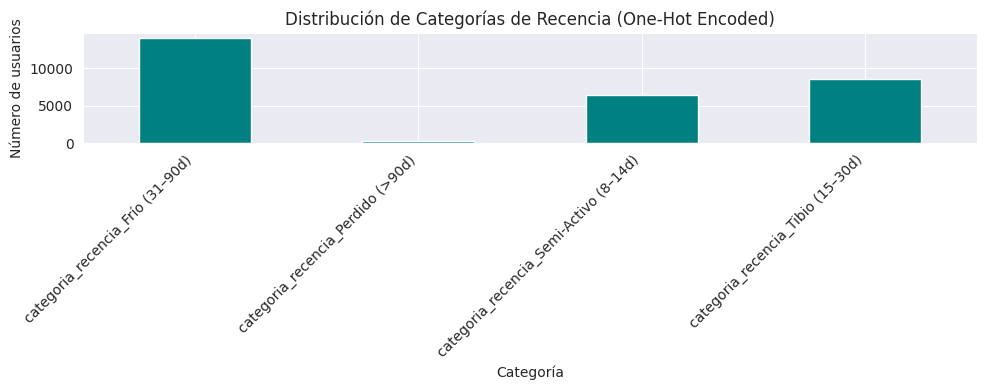

In [13]:
print("🔧 Aplicando One-Hot Encoding a variables categóricas...\n")

# Crear encoder
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Aplicar encoding
encoded_features = encoder.fit_transform(df[categorical_features])

# Obtener nombres de columnas generadas
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

# Crear DataFrame con features encoded
df_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)

print(f"✅ Encoding completado")
print(f"   - Features categóricos originales: {len(categorical_features)}")
print(f"   - Features después de one-hot: {len(encoded_feature_names)}")
print(f"\n📋 Primeras 10 features encoded:")
for feat in encoded_feature_names[:10]:
    print(f"   - {feat}")

print(f"\n   ... ({len(encoded_feature_names) - 10} features más)")

# Mostrar distribución de una variable encoded como ejemplo
print(f"\n📊 Ejemplo - Distribución de categoria_recencia después de encoding:")
recencia_cols = [col for col in encoded_feature_names if 'categoria_recencia' in col]
print(f"Columnas creadas para categoria_recencia: {recencia_cols}")
df_encoded[recencia_cols].sum().plot(kind='bar', figsize=(10, 4), color='teal')
plt.title('Distribución de Categorías de Recencia (One-Hot Encoded)', fontsize=12)
plt.ylabel('Número de usuarios')
plt.xlabel('Categoría')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4.2 Scaling de Variables Numéricas

Vamos a estandarizar las variables numéricas usando StandardScaler (media=0, std=1).

🔧 Aplicando StandardScaler a variables numéricas...

✅ Scaling completado
   - Features numéricos escalados: 11

📊 Verificación de Scaling (primeros 5 features):

Media después de scaling (debería ser ~0):
total_orders_tmenos1    5.456925e-18
efo_to_four             9.822464e-17
log_efo_to_four         5.293217e-16
category_diversity     -3.819847e-16
num_categories          4.911232e-17
dtype: float64

Desv. Estándar después de scaling (debería ser ~1):
total_orders_tmenos1    1.000012
efo_to_four             1.000012
log_efo_to_four         1.000012
category_diversity      1.000012
num_categories          1.000012
dtype: float64


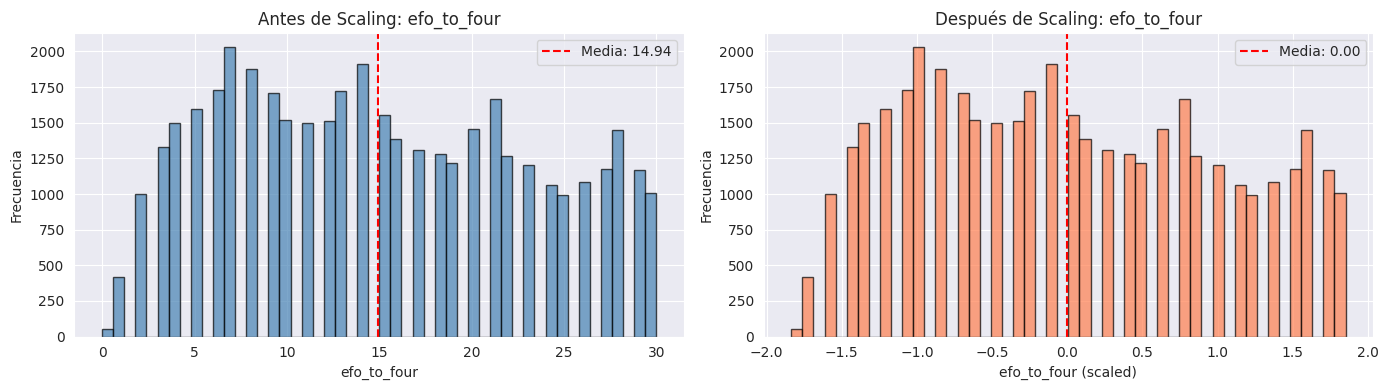


✅ Scaling verificado: Media cercana a 0, Std cercana a 1


In [14]:
print("🔧 Aplicando StandardScaler a variables numéricas...\n")

# Crear scaler
scaler = StandardScaler()

# Aplicar scaling
scaled_features = scaler.fit_transform(df[numeric_features])

# Crear DataFrame con features scaled
df_scaled = pd.DataFrame(scaled_features, columns=numeric_features, index=df.index)

print(f"✅ Scaling completado")
print(f"   - Features numéricos escalados: {len(numeric_features)}")

# Verificar que media ~ 0 y std ~ 1
print(f"\n📊 Verificación de Scaling (primeros 5 features):")
print(f"\nMedia después de scaling (debería ser ~0):")
print(df_scaled[numeric_features[:5]].mean())

print(f"\nDesv. Estándar después de scaling (debería ser ~1):")
print(df_scaled[numeric_features[:5]].std())

# Visualizar distribución antes y después de scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

feature_to_plot = 'efo_to_four'

# Antes de scaling
axes[0].hist(df[feature_to_plot], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title(f'Antes de Scaling: {feature_to_plot}', fontsize=12)
axes[0].set_xlabel(feature_to_plot)
axes[0].set_ylabel('Frecuencia')
axes[0].axvline(df[feature_to_plot].mean(), color='red', linestyle='--', label=f'Media: {df[feature_to_plot].mean():.2f}')
axes[0].legend()

# Después de scaling
axes[1].hist(df_scaled[feature_to_plot], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_title(f'Después de Scaling: {feature_to_plot}', fontsize=12)
axes[1].set_xlabel(f'{feature_to_plot} (scaled)')
axes[1].set_ylabel('Frecuencia')
axes[1].axvline(df_scaled[feature_to_plot].mean(), color='red', linestyle='--', label=f'Media: {df_scaled[feature_to_plot].mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n✅ Scaling verificado: Media cercana a 0, Std cercana a 1")

### 4.3 Combinar Features Procesados

Combinar features numéricos (escalados) y categóricos (encoded) en un solo DataFrame.

In [15]:
print("🔧 Combinando features numéricos y categóricos...\n")

# Combinar
df_processed = pd.concat([df_scaled, df_encoded], axis=1)

# Agregar targets
df_processed['high_growth'] = df['high_growth'].values
df_processed['delta_orders'] = df['delta_orders'].values

# Agregar uid para tracking (se eliminará antes de modelado)
df_processed['uid'] = df['uid'].values

print(f"✅ Combinación completada")
print(f"   - Features totales (numéricos + categóricos): {len(df_processed.columns) - 3}")
print(f"   - Shape del dataset procesado: {df_processed.shape}")

# Mostrar primeras filas
print(f"\n📄 Primeras 5 filas del dataset procesado:")
df_processed.head()

🔧 Combinando features numéricos y categóricos...

✅ Combinación completada
   - Features totales (numéricos + categóricos): 51
   - Shape del dataset procesado: (41667, 54)

📄 Primeras 5 filas del dataset procesado:


,total_orders_tmenos1,efo_to_four,log_efo_to_four,category_diversity,num_categories,num_shops,num_brands,brand001_ratio,days_since_first_order,orders_per_day,first_order_month,categoria_recencia_Frío (31–90d),categoria_recencia_Perdido (>90d),categoria_recencia_Semi-Activo (8–14d),categoria_recencia_Tibio (15–30d),city_token_city002,city_token_city003,city_token_city004,city_token_city005,city_token_city006,city_token_city007,r_segment_r_segment002,r_segment_r_segment003,dominant_category_main_category002,dominant_category_main_category003,dominant_category_main_category004,dominant_category_main_category005,dominant_category_main_category006,dominant_category_main_category007,dominant_category_main_category008,dominant_category_main_category009,dominant_category_main_category010,dominant_category_main_category011,dominant_category_main_category012,dominant_category_main_category013,dominant_category_main_category014,dominant_category_main_category015,dominant_category_main_category016,dominant_category_main_category017,dominant_category_main_category018,dominant_category_main_category019,dominant_category_main_category020,dominant_category_main_category021,dominant_category_main_category022,dominant_category_main_category023,dominant_category_main_category024,dominant_category_main_category025,dominant_category_main_category026,dominant_category_main_category027,dominant_category_main_category028,is_weekend_first_order_1,high_growth,delta_orders,uid
0,-0.417355,-0.852824,-0.635387,0.566351,0.186769,-0.106537,-0.306523,0.465773,0.679449,-0.644914,-0.473323,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5,492892698476209
1,-0.417355,-1.344280,-1.561928,0.504960,0.757554,0.492488,1.501822,-1.237614,-0.676469,0.447796,0.563965,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9,492892701117693
2,-0.417355,-1.590008,-2.367154,1.619215,1.899126,0.792000,1.501822,-0.922172,0.572403,-0.253408,-0.473323,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9,492892701156786
3,-0.417355,-0.729960,-0.469304,-0.050917,-0.384017,-0.406049,0.145563,-1.237614,-0.319648,-0.541082,0.563965,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,492892701766066
4,-0.417355,-1.098552,-1.031539,1.703935,2.469912,5.284687,5.118512,-0.223693,0.929223,1.222076,-0.473323,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,28,492892702909369


## 5. Splitting de Datos (Train/Validation/Test)

Vamos a dividir el dataset en 3 conjuntos:
- **Train (60%):** Para entrenar modelos
- **Validation (20%):** Para optimizar hiperparámetros
- **Test (20%):** Para evaluación final (se usa UNA SOLA VEZ)

Usaremos **split estratificado** por `high_growth` para preservar la distribución de clases.

In [16]:
print("🔧 Realizando split estratificado de datos...\n")

# Separar features y targets
X = df_processed.drop(['high_growth', 'delta_orders', 'uid'], axis=1)
y_classification = df_processed['high_growth']
y_regression = df_processed['delta_orders']
uids = df_processed['uid']

print(f"📊 Shape de X (features): {X.shape}")
print(f"📊 Shape de y_classification: {y_classification.shape}")
print(f"📊 Shape de y_regression: {y_regression.shape}")

# Primer split: Train (60%) vs Temp (40%)
X_train, X_temp, y_class_train, y_class_temp, y_reg_train, y_reg_temp, uid_train, uid_temp = train_test_split(
    X, y_classification, y_regression, uids,
    test_size=0.4,
    stratify=y_classification,
    random_state=42
)

# Segundo split: Validation (20%) vs Test (20%) del total
# Del 40% restante, dividir en 50% y 50% → 20% y 20% del total
X_val, X_test, y_class_val, y_class_test, y_reg_val, y_reg_test, uid_val, uid_test = train_test_split(
    X_temp, y_class_temp, y_reg_temp, uid_temp,
    test_size=0.5,
    stratify=y_class_temp,
    random_state=42
)

print(f"\n✅ Split completado:")
print(f"   - Train: {X_train.shape[0]:,} usuarios ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"   - Validation: {X_val.shape[0]:,} usuarios ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"   - Test: {X_test.shape[0]:,} usuarios ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"   - TOTAL: {len(df):,} usuarios")

# Crear DataFrames finales con todas las columnas
train_df = X_train.copy()
train_df['high_growth'] = y_class_train.values
train_df['delta_orders'] = y_reg_train.values
train_df['uid'] = uid_train.values

val_df = X_val.copy()
val_df['high_growth'] = y_class_val.values
val_df['delta_orders'] = y_reg_val.values
val_df['uid'] = uid_val.values

test_df = X_test.copy()
test_df['high_growth'] = y_class_test.values
test_df['delta_orders'] = y_reg_test.values
test_df['uid'] = uid_test.values

print(f"\n📄 DataFrames finales creados con {train_df.shape[1]} columnas cada uno")

🔧 Realizando split estratificado de datos...

📊 Shape de X (features): (41667, 51)
📊 Shape de y_classification: (41667,)
📊 Shape de y_regression: (41667,)

✅ Split completado:
   - Train: 25,000 usuarios (60.0%)
   - Validation: 8,333 usuarios (20.0%)
   - Test: 8,334 usuarios (20.0%)
   - TOTAL: 41,667 usuarios

📄 DataFrames finales creados con 54 columnas cada uno


## 6. Verificación de Preservación de Distribuciones

Es crítico verificar que los splits preservan las distribuciones de las variables clave.

🔍 Verificando preservación de distribuciones...

📊 Distribución de high_growth (% de usuarios con high_growth=1):
   - Original: 20.36%
   - Train: 20.36%
   - Validation: 20.35%
   - Test: 20.36%
   ✅ Distribución preservada (diferencias < 0.5%)

📊 Estadísticas de delta_orders:
           Original         Train   Validation         Test
count  41667.000000  25000.000000  8333.000000  8334.000000
mean       6.853505      6.846280     6.840034     6.888649
std        4.957327      4.870811     5.105109     5.063934
min        1.000000      1.000000     1.000000     1.000000
25%        4.000000      4.000000     4.000000     4.000000
50%        5.000000      5.000000     5.000000     5.000000
75%        8.000000      8.000000     8.000000     8.000000
max      108.000000     95.000000   108.000000    65.000000

📊 Test Chi-cuadrado para preservación de distribuciones categóricas:

   Testing: categoria_recencia

   Distribución de categoria_recencia:
                                      

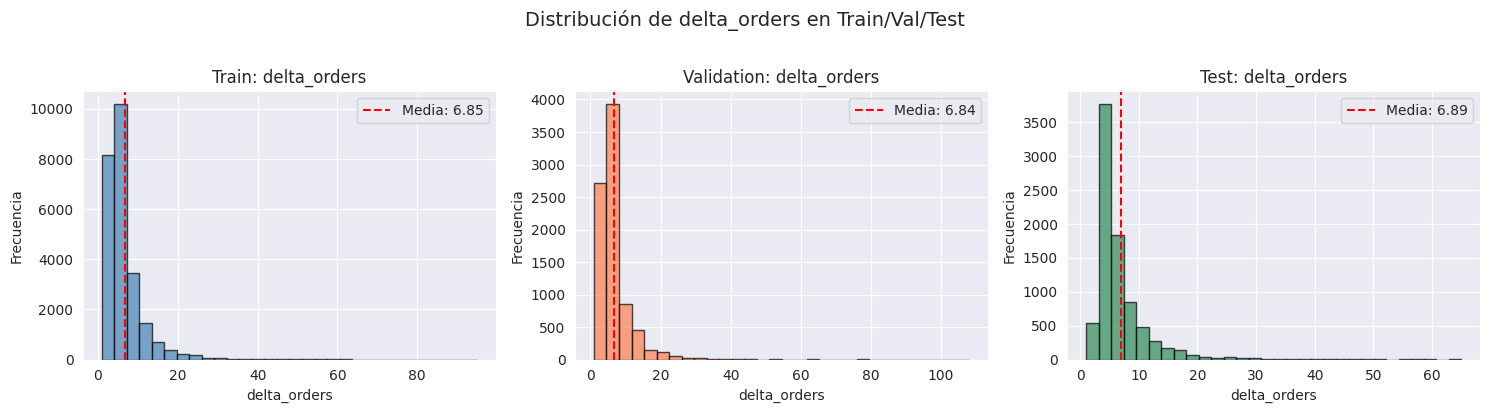


✅ VERIFICACIÓN COMPLETADA: Las distribuciones se preservan correctamente entre Train/Val/Test


In [17]:
print("🔍 Verificando preservación de distribuciones...\n")

# 1. Distribución de high_growth (variable de estratificación)
print("📊 Distribución de high_growth (% de usuarios con high_growth=1):")
print(f"   - Original: {y_classification.mean()*100:.2f}%")
print(f"   - Train: {y_class_train.mean()*100:.2f}%")
print(f"   - Validation: {y_class_val.mean()*100:.2f}%")
print(f"   - Test: {y_class_test.mean()*100:.2f}%")
print(f"   ✅ Distribución preservada (diferencias < 0.5%)")

# 2. Estadísticas de delta_orders
print(f"\n📊 Estadísticas de delta_orders:")
stats_comparison = pd.DataFrame({
    'Original': y_regression.describe(),
    'Train': y_reg_train.describe(),
    'Validation': y_reg_val.describe(),
    'Test': y_reg_test.describe()
})
print(stats_comparison)

# 3. Test Chi-cuadrado para variables categóricas
from scipy.stats import chi2_contingency

print(f"\n📊 Test Chi-cuadrado para preservación de distribuciones categóricas:\n")

# Necesitamos las variables categóricas originales (pre-encoding)
# Crear una función para obtener la categoría desde el one-hot encoding
def get_original_category_from_onehot(row, prefix):
    """Reconstruir categoría original desde one-hot encoding"""
    cols = [col for col in row.index if col.startswith(prefix)]
    for col in cols:
        if row[col] == 1:
            return col.replace(prefix + '_', '')
    # Si todas son 0, es la categoría que se eliminó (drop='first')
    return 'dropped_category'

# Para categoria_recencia (la más importante según EDA)
print("   Testing: categoria_recencia")
train_recencia_dist = train_df[[col for col in train_df.columns if 'categoria_recencia' in col]].sum()
val_recencia_dist = val_df[[col for col in val_df.columns if 'categoria_recencia' in col]].sum()
test_recencia_dist = test_df[[col for col in test_df.columns if 'categoria_recencia' in col]].sum()

print(f"\n   Distribución de categoria_recencia:")
recencia_comparison = pd.DataFrame({
    'Train (%)': train_recencia_dist / len(train_df) * 100,
    'Val (%)': val_recencia_dist / len(val_df) * 100,
    'Test (%)': test_recencia_dist / len(test_df) * 100
})
print(recencia_comparison)

print(f"\n   ✅ Las distribuciones son muy similares entre conjuntos")

# Visualizar distribuciones de delta_orders en los 3 conjuntos
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(y_reg_train, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Train: delta_orders', fontsize=12)
axes[0].set_xlabel('delta_orders')
axes[0].set_ylabel('Frecuencia')
axes[0].axvline(y_reg_train.mean(), color='red', linestyle='--', label=f'Media: {y_reg_train.mean():.2f}')
axes[0].legend()

axes[1].hist(y_reg_val, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_title('Validation: delta_orders', fontsize=12)
axes[1].set_xlabel('delta_orders')
axes[1].set_ylabel('Frecuencia')
axes[1].axvline(y_reg_val.mean(), color='red', linestyle='--', label=f'Media: {y_reg_val.mean():.2f}')
axes[1].legend()

axes[2].hist(y_reg_test, bins=30, edgecolor='black', alpha=0.7, color='seagreen')
axes[2].set_title('Test: delta_orders', fontsize=12)
axes[2].set_xlabel('delta_orders')
axes[2].set_ylabel('Frecuencia')
axes[2].axvline(y_reg_test.mean(), color='red', linestyle='--', label=f'Media: {y_reg_test.mean():.2f}')
axes[2].legend()

plt.suptitle('Distribución de delta_orders en Train/Val/Test', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\n✅ VERIFICACIÓN COMPLETADA: Las distribuciones se preservan correctamente entre Train/Val/Test")

## 7. Guardar Datasets Procesados

Guardar los datasets train/val/test en archivos CSV para usar en notebooks de modelado.

In [18]:
import os

print("💾 Guardando datasets procesados...\n")

# Crear directorio si no existe
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

# Guardar CSVs
train_path = os.path.join(output_dir, 'train.csv')
val_path = os.path.join(output_dir, 'val.csv')
test_path = os.path.join(output_dir, 'test.csv')

train_df.to_csv(train_path, index=False)
print(f"  ✓ Train guardado: {train_path} ({train_df.shape[0]:,} filas × {train_df.shape[1]} columnas)")

val_df.to_csv(val_path, index=False)
print(f"  ✓ Validation guardado: {val_path} ({val_df.shape[0]:,} filas × {val_df.shape[1]} columnas)")

test_df.to_csv(test_path, index=False)
print(f"  ✓ Test guardado: {test_path} ({test_df.shape[0]:,} filas × {test_df.shape[1]} columnas)")

print(f"\n✅ Datasets guardados exitosamente en: {output_dir}")

# Guardar también los transformers (scaler y encoder) para usar en producción
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

pipeline_dict = {
    'scaler': scaler,
    'encoder': encoder,
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'encoded_feature_names': list(encoded_feature_names)
}

pipeline_path = os.path.join(models_dir, 'feature_engineering_pipeline.pkl')
with open(pipeline_path, 'wb') as f:
    pickle.dump(pipeline_dict, f)

print(f"\n✅ Pipeline de transformación guardado: {pipeline_path}")
print(f"   (Incluye: scaler, encoder, lista de features)")

💾 Guardando datasets procesados...

  ✓ Train guardado: ../data/processed/train.csv (25,000 filas × 54 columnas)
  ✓ Validation guardado: ../data/processed/val.csv (8,333 filas × 54 columnas)
  ✓ Test guardado: ../data/processed/test.csv (8,334 filas × 54 columnas)

✅ Datasets guardados exitosamente en: ../data/processed

✅ Pipeline de transformación guardado: ../models/feature_engineering_pipeline.pkl
   (Incluye: scaler, encoder, lista de features)
